# Introduction

The problem involves locating the safest neighborhood in which to live in the city of Philadelphia. The investment needed for choosing a place to live is such that it requires necessary and in-depth research before making such a massive decision.

The goal of this project is to determine the safest neighborhood in which to live within the city of Philadelphia, Pennsylvania. To do this, we would analyze crime data for the city, the available venues such as restaurants, schools, bars, grocery stores, hospitals, etc., within each neighborhood with the goal of finding the best area to live in Philadelphia.

# Data

We will be using the geographical coordinates of Philadelphia to plot neighborhoods in a section that is safe and affordable and within in the city, and cluster the neighborhoods and present the findings.

The following data sources will be used:

- Real world data set from OpenDataPhilly containing the Philadelphia Crimes in 2019: A dataset consisting of the crime statistics of each section of Philadelphia along with type of crime.

- Consolidating datasets to include crime rates and types of crime, home sale prices, longitude and latitude of locations, etc.

- Use Four Square API to add location and venue info to dataset to include restaurants, bars, schools, etc.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
!pip install --upgrade geocoder
import geocoder
import os
!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
print('Libraries imported.')

     |████████████████████████████████| 102kB 9.5MB/s eta 0:00:01
Requirement already up-to-date: geocoder in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.38.1)
     |████████████████████████████████| 102kB 10.3MB/s ta 0:00:01
Libraries imported.


Import dataset

In [2]:
import pandas
df = pd.read_csv(r'https://raw.githubusercontent.com/tjh7019/Capstone_Week_4/master/incidents_part1_part2.csv')

In [3]:
df.head()

,objectid,dc_dist,dispatch_date,dispatch_time,location_block,text_general_code,point_x,point_y,lat,lng
0,120,9,11/12/19,9:59:00,100 BLOCK S BROAD ST,Thefts,-75.066628,40.049264,40.049264,-75.066628
1,128,9,1/19/19,17:20:00,1400 BLOCK SPRING GARDEN ST,Thefts,-75.161446,39.962334,39.962334,-75.161446
2,53,77,12/14/19,8:07:00,0 BLOCK PIA WAY,Thefts,-75.230706,39.883881,39.883881,-75.230706
3,54,77,12/24/19,14:03:00,0 BLOCK PIA WAY,Thefts,-75.230706,39.883881,39.883881,-75.230706
4,55,77,12/25/19,16:29:00,0 BLOCK PIA WAY,Thefts,-75.230706,39.883881,39.883881,-75.230706


In [4]:
#The dataset is quite large; so let's check the dimensions
print("Data dimensions: df")
print(df.shape)

Data dimensions: df
(161087, 10)


In [5]:
#Print the column names and values to see if there is any way to clean the data
print("Column values: df")
print(df.columns.values)
print("\n")

pd.options.display.float_format = '{:,.2f}'.format
print("Data Set Description:")
print(df.describe())

Column values: df
['objectid' 'dc_dist' 'dispatch_date' 'dispatch_time' 'location_block'
 'text_general_code' 'point_x' 'point_y' 'lat' 'lng']


Data Set Description:
          objectid    dc_dist    point_x    point_y        lat        lng
count   161,087.00 161,087.00 161,087.00 161,087.00 161,087.00 161,087.00
mean  1,300,420.38      17.97     -75.22      39.87      39.87     -75.22
std     763,740.72      10.72       0.67       1.20       1.20       0.67
min          53.00       1.00     -81.58      28.42      28.42     -81.58
25%     644,738.50       9.00     -75.19      39.96      39.96     -75.19
50%   1,284,304.00      17.00     -75.16      39.99      39.99     -75.16
75%   1,991,494.00      24.00     -75.12      40.02      40.02     -75.12
max   2,611,899.00      77.00     -74.96      40.14      40.14     -74.96


In [6]:
#The objectid column is not really necessary for our purposes, so let's eliminate that column.
df.drop('objectid', axis=1, inplace=True)

In [7]:
df.head()

,dc_dist,dispatch_date,dispatch_time,location_block,text_general_code,point_x,point_y,lat,lng
0,9,11/12/19,9:59:00,100 BLOCK S BROAD ST,Thefts,-75.07,40.05,40.05,-75.07
1,9,1/19/19,17:20:00,1400 BLOCK SPRING GARDEN ST,Thefts,-75.16,39.96,39.96,-75.16
2,77,12/14/19,8:07:00,0 BLOCK PIA WAY,Thefts,-75.23,39.88,39.88,-75.23
3,77,12/24/19,14:03:00,0 BLOCK PIA WAY,Thefts,-75.23,39.88,39.88,-75.23
4,77,12/25/19,16:29:00,0 BLOCK PIA WAY,Thefts,-75.23,39.88,39.88,-75.23


In [8]:
#Let's explore some of the info in the columns to see if we can further streamline the data
dc_dist_distinct = df.groupby('dc_dist')['dc_dist'].count()
print(dc_dist_distinct)
print("\n")

text_general_code_distinct = df.groupby('text_general_code')['text_general_code'].size()
print(text_general_code_distinct)

dc_dist
1      2560
2      6611
3      7160
5      2260
6      8482
7      2497
8      4312
9      7799
12     8369
14     8626
15    10981
16     6765
17     4650
18     9107
19    10745
22    10932
24    13546
25     9510
26     5699
35    10797
39     9013
77      666
Name: dc_dist, dtype: int64


text_general_code
Aggravated Assault Firearm                  2621
Aggravated Assault No Firearm               5601
All Other Offenses                         30739
Arson                                        436
Burglary Non-Residential                    1355
Burglary Residential                        4770
DRIVING UNDER THE INFLUENCE                 2346
Disorderly Conduct                           937
Embezzlement                                 404
Forgery and Counterfeiting                   234
Fraud                                       9755
Gambling Violations                           75
Homicide - Criminal                          300
Homicide - Criminal                        

The next cleaning step involves the 911 calls. If multiple people placed a 911 call for the same incident, the incident is recorded twice in this data set. These rows must be combined so that each incident is counted only once regardless of the number of 911 callers.

In [9]:
df = df.drop_duplicates(['dispatch_date', 'dispatch_time', 'location_block', 'text_general_code'])

In [10]:
print("Data dimensions: df")
print(df.shape)

Data dimensions: df
(157177, 9)


Univariant analysis is shown below for crime type, police district, year, month, and hour.

The five worst police districts are the 15th, 19th, 22nd, 24th, and 35th. The 15th (Mayfair section) and 35th (Fern Rock) districts are in northeastern Philadelphia, which has traditionally been the highest-crime area of the city; the 19th is in the southwestern (Haddington) section. The 22nd is in North Central Philadelphia, and the 24th is in the East (Feltonville) district. The districts with the fewest incidents are the far Northwest 5th (Roxborough), 7th (Bustleton) far northeast, and 1st (near stadiums and naval yard).

In [11]:
df.loc[df.dc_dist == 77, 'dc_dist'] = 12

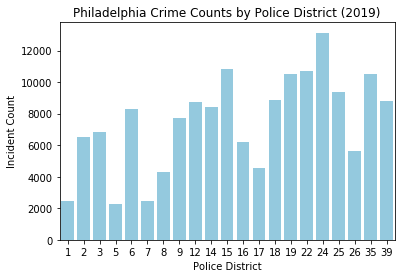

In [12]:
# What parts of the city have the most crime?
import seaborn as sns
dist_bins = np.array([1, 2, 3, 5, 6, 7, 8, 9, 12, 14, 15, 16, 17, 18, 19, 22, 24, 25, 26, 35, 39])
sns.countplot(df['dc_dist'], color='skyblue')
plt.title("Philadelphia Crime Counts by Police District (2019)")
plt.xlabel("Police District")
plt.ylabel("Incident Count")
plt.show()

The most common crime types are Theft, Vandalism, Drug Violations, "Other" Assaults, and "All Other Offenses".

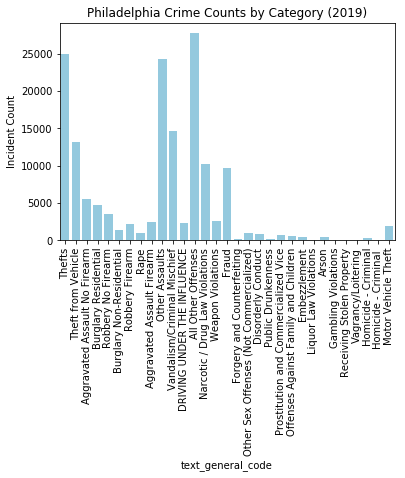

In [13]:
ucr_bins = np.arange(50,2650,100)
sns.countplot(df['text_general_code'], color='skyblue')
plt.title("Philadelphia Crime Counts by Category (2019)")
plt.xlabel("text_general_code")
plt.ylabel("Incident Count")
plt.xticks(rotation=90)
plt.show()

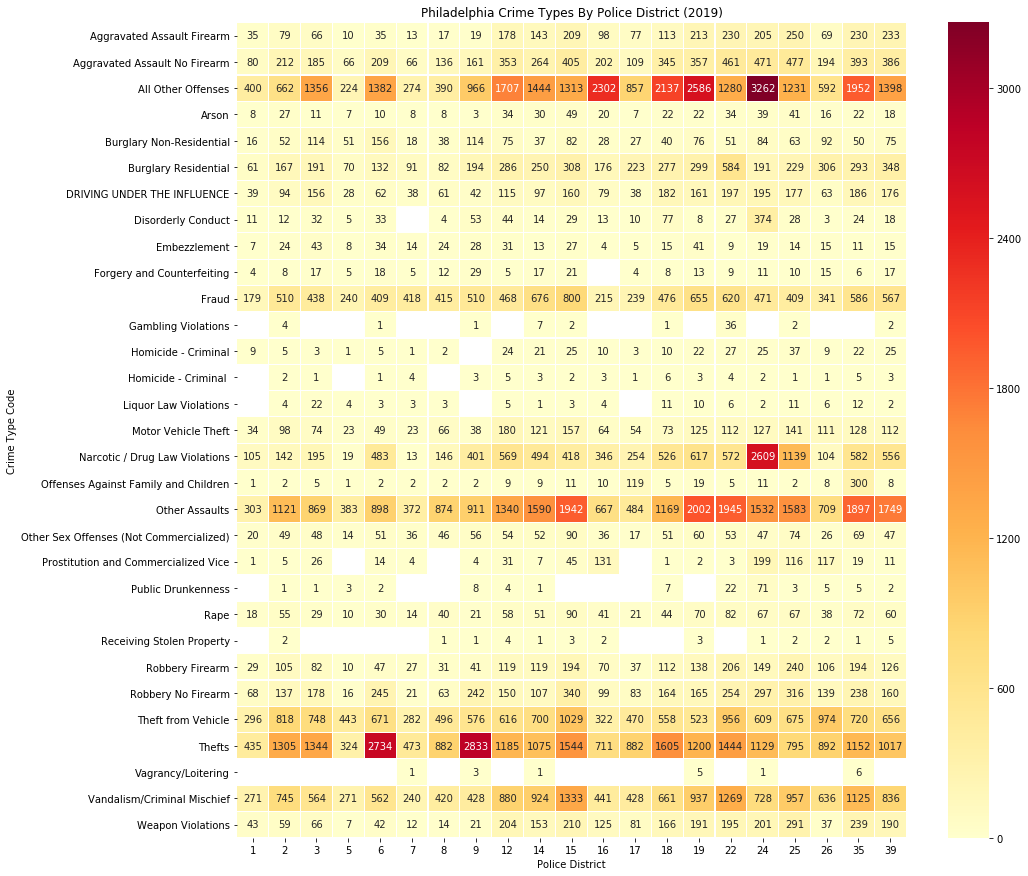

In [14]:
# Crime types by police district
df_type_dist = df.groupby(['text_general_code', 'dc_dist']).size()
df_type_dist = df_type_dist.apply(int)
df_type_dist_df = df_type_dist.to_frame()
df_type_dist_pt = pd.pivot_table(df_type_dist_df, index=['text_general_code'], columns=['dc_dist'])[0] # Get rid of '0 column'

# Heatmap representation
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data=df_type_dist_pt, annot=True, linewidths=0.1, fmt='g', cmap="YlOrRd", ax=ax)
plt.title("Philadelphia Crime Types By Police District (2019)")
plt.xlabel("Police District")
plt.ylabel("Crime Type Code")
plt.show()

Now that we have determined the safest districts in Philadelphia with the lowest crime rates, let's apply Four Square geodata to find the districts with the most restaurants, parks, bars, etc.

In [15]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="Mozilla/5.0 (iPhone; CPU iPhone OS 10_3 like Mac OS X) AppleWebKit/602.1.50 (KHTML, like Gecko) CriOS/56.0.2924.75 Mobile/14E5239e Safari/602.1")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [16]:
CLIENT_ID = 'N21BZZA3TT2UUA3ZX05HZZUO1NZKSLBFPXRH0GY3MOWJJJKD' # your Foursquare ID
CLIENT_SECRET = 'WFCYUYX11LVWNJVR1D4WW3EGXUME24R4WPNSKQ2DGGG0A3P1' # your Foursquare Secret
VERSION = '20200901'
LIMIT = 20
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: N21BZZA3TT2UUA3ZX05HZZUO1NZKSLBFPXRH0GY3MOWJJJKD
CLIENT_SECRET:WFCYUYX11LVWNJVR1D4WW3EGXUME24R4WPNSKQ2DGGG0A3P1


In [17]:
df.shape

(157177, 9)

In [18]:
import pandas
df1 = pd.read_csv(r'https://raw.githubusercontent.com/tjh7019/Capstone_Week_4/master/Phila_data.csv')

In [19]:
df1.head()

,dc_dist,location_block,lat,lng
0,9,100 BLOCK S BROAD ST,40.05,-75.07
1,9,1400 BLOCK SPRING GARDEN ST,39.96,-75.16
2,6,300 BLOCK S 13TH ST,39.95,-75.16
3,6,300 BLOCK S 13TH ST,39.95,-75.16
4,25,400 BLOCK CASKEY ST,40.02,-75.13


Since we know that district 5 is the safest in the city of Philadelphia, let's eliminate all of the other districts and focus on locating venues within district 5.

In [36]:
indexNames = df1[ df1['dc_dist'] > 5 ].index

In [37]:
df1.head()

,dc_dist,location_block,lat,lng
7,3,2100 BLOCK S 10TH ST,39.92,-75.16
22,3,2100 BLOCK SO 10TH ST,39.92,-75.16
23,3,2100 BLOCK S 10TH ST,39.92,-75.16
24,3,2100 BLOCK S 10TH ST,39.92,-75.16
63,5,8200 BLOCK HENRY AVE,40.06,-75.23


In [40]:
df1.shape

(18591, 4)

In [38]:
df1.drop(indexNames , inplace=True)

In [39]:
df1.head()

,dc_dist,location_block,lat,lng
7,3,2100 BLOCK S 10TH ST,39.92,-75.16
22,3,2100 BLOCK SO 10TH ST,39.92,-75.16
23,3,2100 BLOCK S 10TH ST,39.92,-75.16
24,3,2100 BLOCK S 10TH ST,39.92,-75.16
63,5,8200 BLOCK HENRY AVE,40.06,-75.23


In [41]:
df1.shape

(18591, 4)

In [42]:
indexNames = df1[ df1['dc_dist'] < 5 ].index

In [44]:
df1.drop(indexNames , inplace=True)

In [45]:
df1.head()

,dc_dist,location_block,lat,lng
63,5,8200 BLOCK HENRY AVE,40.06,-75.23
64,5,8200 BLOCK HENRY AVE,40.06,-75.23
65,5,8200 BLOCK HENRY AVE,40.06,-75.23
66,5,8200 BLOCK HENRY AVE,40.06,-75.23
67,5,8200 BLOCK HENRY AV,40.06,-75.23


In [46]:
df1.shape

(2260, 4)

We've now managed to cull a very large list down to include only district 5, which had 2,260 total crimes committed in 2019, the fewest in the city of Philadelphia. Now, let's locate venues within this district.

In [47]:
df1

,dc_dist,location_block,lat,lng
63,5,8200 BLOCK HENRY AVE,40.06,-75.23
64,5,8200 BLOCK HENRY AVE,40.06,-75.23
65,5,8200 BLOCK HENRY AVE,40.06,-75.23
66,5,8200 BLOCK HENRY AVE,40.06,-75.23
67,5,8200 BLOCK HENRY AV,40.06,-75.23
68,5,8200 BLOCK HENRY AV E9,40.06,-75.23
69,5,8200 BLOCK HENRY AVE E9,40.06,-75.23
70,5,8200 BLOCK HENRY AVE E9,40.06,-75.23
71,5,8200 BLOCK HENRY AVE,40.06,-75.23
129,5,7900 BLOCK HENRY AV,40.06,-75.23


In [73]:
df1.loc[40984, 'dc_dist']

5

In [75]:
dc_dist_lat = df1.loc[40984, 'lat']
dc_dist_long = df1.loc[40984, 'lng']
dc_dist_loc = df1.loc[40984, 'dc_dist']

print('The latitude and longitude values of {} are {}, {}.'.format(dc_dist_loc,
                                                                            dc_dist_lat,
                                                                            dc_dist_long))

The latitude and longitude values of 5 are 40.04427872, -75.23199262.


In [76]:
# Credentials are provided already for this part
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    dc_dist_lat, 
    dc_dist_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=N21BZZA3TT2UUA3ZX05HZZUO1NZKSLBFPXRH0GY3MOWJJJKD&client_secret=WFCYUYX11LVWNJVR1D4WW3EGXUME24R4WPNSKQ2DGGG0A3P1&v=20200901&ll=40.04427872,-75.23199262&radius=2000&limit=100'

In [62]:
import json

In [63]:
from pandas.io.json import json_normalize
print('json_normalize imported...')

json_normalize imported...


In [77]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f4fc4417c1c9e0994cb2090'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Roxborough',
  'headerFullLocation': 'Roxborough, Philadelphia',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 77,
  'suggestedBounds': {'ne': {'lat': 40.06227873800002,
    'lng': -75.20852391192268},
   'sw': {'lat': 40.026278701999985, 'lng': -75.25546132807732}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ba52e31f964a5207ee838e3',
       'name': "Rita's Water Ice",
       'location': {'address': '7132 Ridge Ave',
        'lat': 40.04444139119077,
        'lng': -75.23196852309964,
        'labeledLatLng

In [78]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [79]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [80]:
nearby_venues

,name,categories,lat,lng
0,Rita's Water Ice,Dessert Shop,40.04,-75.23
1,Wissahickon Valley Park,Park,40.05,-75.23
2,Tony Roni's Pizza Roxborough,Pizza Place,40.05,-75.23
3,T&F Farmer's Pride,Grocery Store,40.06,-75.24
4,Mel's Kitchen,American Restaurant,40.04,-75.24
5,ShopRite,Supermarket,40.04,-75.23
6,Popeyes Louisiana Kitchen,Fried Chicken Joint,40.04,-75.23
7,Starbucks,Coffee Shop,40.04,-75.23
8,Crossfit Manayunk,Gym,40.03,-75.23
9,Wawa,Convenience Store,40.04,-75.22


In [83]:
nearby_venues_dc_dist_5_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [84]:
nearby_venues_dc_dist_5_unique.head(5)

,Count
Sandwich Place,4
Chinese Restaurant,3
Gym,3
Pizza Place,3
Liquor Store,3


In [85]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

77 venues were returned by Foursquare.


# Conclusion

Based on the crime data listed above, district 5 (Roxborough) section of Philadelphia, PA, is the safest neighborhood in which to live in the city.